In [11]:
#Install Required Libraries
#!pip install PyPDF2 spacy pandas numpy matplotlib seaborn scikit-learn sentence-transformers pytesseract pdf2image

# Install the SpaCy model
#!python -m spacy download en_core_web_sm
#!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 8.5 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


### 2. Data Extracting
Textual data needs to be further
analysed to extract relevant information from each document, the data extracted can be
used as features for a downstream modelling task.

In [10]:
import os
import PyPDF2
from pdf2image import convert_from_path
import pytesseract
import re
import spacy
import pandas as pd

# Load metadata
metadata = pd.read_csv('/workspaces/project-2-ombudsman/metadata.csv')

# Function to extract text with PyPDF2
def extract_text_with_pypdf2(file_path):
    text = ''
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page_num in range(len(reader.pages)):
                page_text = reader.pages[page_num].extract_text()
                if page_text:
                    text += page_text
    except Exception as e:
        print(f"Failed to extract text from {file_path} using PyPDF2: {e}")
    return text

# Extract text from all PDFs in specified directories
def extract_text_from_pdfs(base_folders):
    pdf_texts = {}
    for base_folder in base_folders:
        for root, dirs, files in os.walk(base_folder):
            for filename in files:
                if filename.endswith('.pdf'):
                    file_path = os.path.join(root, filename)
                    text = extract_text_with_pypdf2(file_path)
                    if not text:
                        text = extract_text_with_ocr(file_path)
                    pdf_texts[filename] = text
                    # Print a snippet of the extracted text for debugging
                    print(f"Extracted text snippet from {filename}: {text[:500]}")  # Debug print
    return pdf_texts

# NLP for data extraction
nlp = spacy.load('en_core_web_sm')

# Set the directories
base_folders = [
    '/workspaces/project-2-ombudsman/04_24_insurance',
    '/workspaces/project-2-ombudsman/05_24_insurance'
]

    #'/workspaces/project-2-ombudsman/12_23_insurance',
    #'/workspaces/project-2-ombudsman/01_24_insurance',
    #'/workspaces/project-2-ombudsman/02_24_insurance',
    #'/workspaces/project-2-ombudsman/03_24_insurance',
# Extract text from all PDFs
pdf_texts = extract_text_from_pdfs(base_folders)


Extracted text snippet from 04_24_Insurance_DRN-4552609.pdf: DRN-4552609
The complaint
Mr C has complained that AXIS Specialty Europe SE has declined a claim he made for 
malicious damage under his commercial property owners insurance policy.
What happened
The background to this complaint is well known to the parties so I won’t repeat it in detail 
here. In summary Mr C rented out a property he owned. The tenant caused damage to that 
property, and one above. AXIS declined the claim Mr C made for malicious damage as it 
considered Mr C had issues with the
Extracted text snippet from 04_24_Insurance_DRN-4647254.pdf: DRN-4647254
The complaint
Mr K the policyholder, and his son also Mr K, the named driver, have complained that AXA 
Insurance UK Plc failed to deal with the other driver’s claim against Mr K’s motor policy 
following an accident in which the named driver was involved. This resulted in a County 
Court Judgement (CCJ) being registered against the named driver.  
This complaint

,filename,text,decision,company
0,04_24_Insurance_DRN-4552609.pdf,DRN-4552609 complain AXIS Specialty Europe SE ...,Not upheld,AXIS Specialty Europe SE
1,04_24_Insurance_DRN-4647254.pdf,DRN-4647254 policyholder son name driver compl...,Not upheld,AXA Insurance UK Plc
2,04_24_Insurance_DRN-4764947.pdf,DRN-4764947 complain Arch Insurance UK Limited...,Upheld,Arch Insurance (UK) Limited
3,04_24_Insurance_DRN-4739493.pdf,DRN-4739493 complain Royal Sun Alliance Insura...,Not upheld,Royal & Sun Alliance Insurance Limited
4,04_24_Insurance_DRN-4730514.pdf,DRN-4730514 company complain way National Farm...,Upheld,The National Farmers' Union Mutual Insurance S...


### Data Cleaning and Preparation: 
As the dataset consists of semi-structured text documents, it will be necessary to extract the relevant information from the downloaded documents.

In [18]:
# Custom stop words
custom_stop_words = set(["say", "said", "investigate", "claim","complaint", "uphold", "not uphold", "time","mean", "accept","reject","ask",
                         "thing","right", "day","month", "year","issue","provide","work", "consider", "include", "report", "previous","investigator",
                         "follow", "decision", "ombudsman", "need", "feel", "think","believe", "may","find", "refer", "item", "request", "give",
                         "rule", "financial", "service", "point", "raise", "lead", "new","show", "use", "question","happen","happened","view", "later",
                         "tell", "note", "look", "case", "base", "go", "going", "went", "event","request", "whilst", "pay",
                         "insurer", "available","arrange","handle","take", "receive","send", "Financial,  Ombudsman Service", "before", "after",
                         "conclude", "comment","final require", "concern", "see", "know", "set", "want", "carry", "likely", "decline", "act fairly",
                         "result", "number", "appear", "require", "record", "decide", "argument", "account", "way", "follow", "position", "appreciate",
                         "decline", "approve", "action", "explain", "compensation", "evidence","matter", "problem", "final reason","apply","policy","quate",
                         "january", "february","march", "april", "may","june","july","august","september","october", "november","december"])

# Data Cleaning and Preparation
def clean_text(text):
    doc = nlp(text)
    tokens = [
        token.lemma_ 
        for token in doc 
        if len(token.text) > 1
        and not token.is_stop and not token.is_punct 
        and not re.match(r'^(Mr|Mrs|Miss|Ms)\.?', token.text)
        and token.lemma_.lower() not in custom_stop_words
    ]
    return ' '.join(tokens)

# Clean the extracted text
cleaned_texts = {filename: clean_text(text) for filename, text in pdf_texts.items()}

# Map decision and company from metadata
def get_metadata_info(filename):
    decision_id = re.search(r'DRN-(\d+)', filename).group(1)
    row = metadata[metadata['decision_id'].str.contains(decision_id)]
    if not row.empty:
        decision = row.iloc[0]['decision']
        company = row.iloc[0]['company']
        return decision, company
    else:
        return None, None

# Example reference list of UK insurance companies
reference_companies = [
    "Aviva", "AXA", "Direct Line", "Zurich", "Allianz", "LV=", "Esure", "Admiral", "Ageas", "RSA",
    "Hiscox", "NFU Mutual", "Saga", "Co-op", "Covea", "Chubb", "Legal & General", "Markerstudy",
    "Churchill", "Swinton", "Tesco Bank", "Virgin Money", "John Lewis", "Sainsbury's", "Halifax",
    "Barclays", "HSBC", "Lloyds Bank", "Santander", "Nationwide"
]

# Example mapping from variations to standard names
company_mapping = {
    "Aviva Insurance Limited": "Aviva",
    "AXA Insurance UK Plc": "AXA",
    "Direct Line Insurance Group Plc": "Direct Line",
    "Zurich Insurance Plc": "Zurich",
    "Allianz Insurance Plc": "Allianz",
    "LV Insurance": "LV=",
    "Esure Insurance": "Esure",
    "Admiral Insurance": "Admiral",
    "Ageas Insurance": "Ageas",
    "RSA Insurance": "RSA",
    "Hiscox Insurance": "Hiscox",
    "NFU Mutual Insurance": "NFU Mutual",
    "Saga Insurance": "Saga",
    "Co-op Insurance": "Co-op",
    "Covea Insurance": "Covea",
    "Chubb Insurance": "Chubb",
    "Legal & General Insurance": "Legal & General",
    "Markerstudy Insurance": "Markerstudy",
    "Churchill Insurance": "Churchill",
    "Swinton Insurance": "Swinton",
    "Tesco Bank Insurance": "Tesco Bank",
    "Virgin Money Insurance": "Virgin Money",
    "John Lewis Insurance": "John Lewis",
    "Sainsbury's Insurance": "Sainsbury's",
    "Halifax Insurance": "Halifax",
    "Barclays Insurance": "Barclays",
    "HSBC Insurance": "HSBC",
    "Lloyds Bank Insurance": "Lloyds Bank",
    "Santander Insurance": "Santander",
    "Nationwide Insurance": "Nationwide",
    # Add other mappings as needed
}

# Function to standardize company names
def standardize_company_name(company):
    company = company.strip()
    if company in company_mapping:
        return company_mapping[company]
    for ref_company in reference_companies:
        if ref_company.lower() in company.lower():
            return ref_company
    return company

# Create dataframe with cleaned texts and corresponding metadata
data = []
for filename, text in cleaned_texts.items():
    decision, company = get_metadata_info(filename)
    if decision and company:
        company = standardize_company_name(company)
        data.append((filename, text, decision, company))

df = pd.DataFrame(data, columns=['filename', 'text', 'decision', 'company'])

# Display cleaned texts for debugging
df.head()

,filename,text,decision,company
0,04_24_Insurance_DRN-4552609.pdf,DRN-4552609 complain AXIS Specialty Europe SE ...,Not upheld,AXIS Specialty Europe SE
1,04_24_Insurance_DRN-4647254.pdf,DRN-4647254 policyholder son name driver compl...,Not upheld,AXA
2,04_24_Insurance_DRN-4764947.pdf,DRN-4764947 complain Arch Insurance UK Limited...,Upheld,Arch Insurance (UK) Limited
3,04_24_Insurance_DRN-4739493.pdf,DRN-4739493 complain Royal Sun Alliance Insura...,Not upheld,Royal & Sun Alliance Insurance Limited
4,04_24_Insurance_DRN-4730514.pdf,DRN-4730514 company complain National Farmers ...,Upheld,The National Farmers' Union Mutual Insurance S...


### 2. Feature Engineering 
Feature Extraction using TF-IDF

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['decision'], test_size=0.2, random_state=42)

# Feature extraction using TF-IDF with more parameters
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### 3. Exploratory Data Analysis (EDA) and 4. Visualization

decision
Not upheld    432
Upheld        407
Name: count, dtype: int64


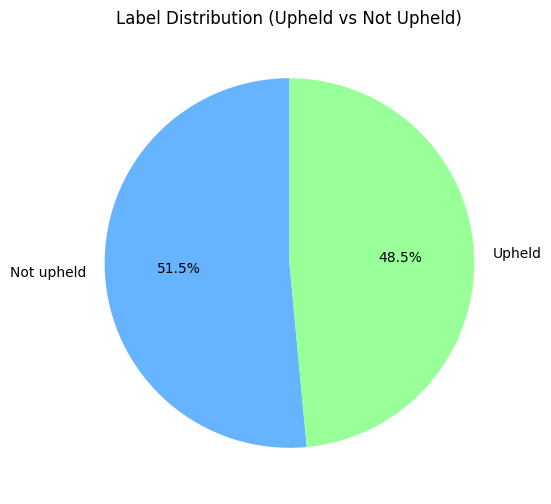

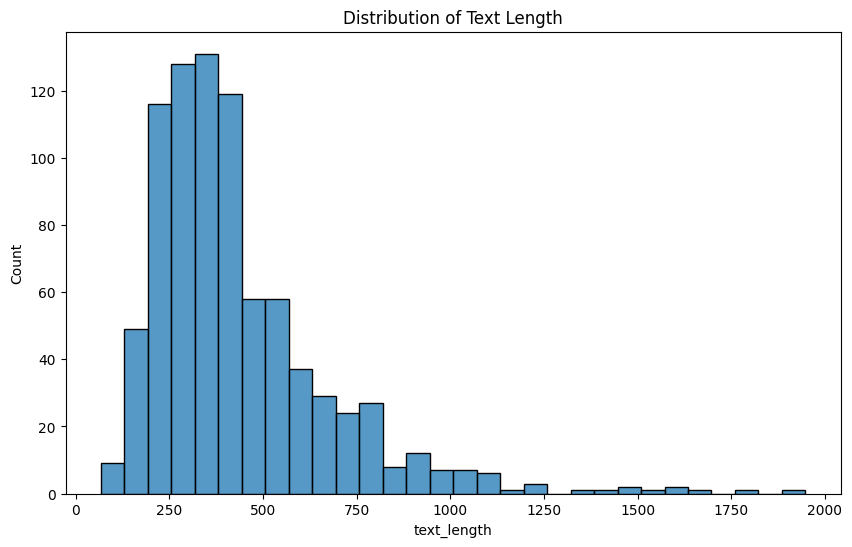

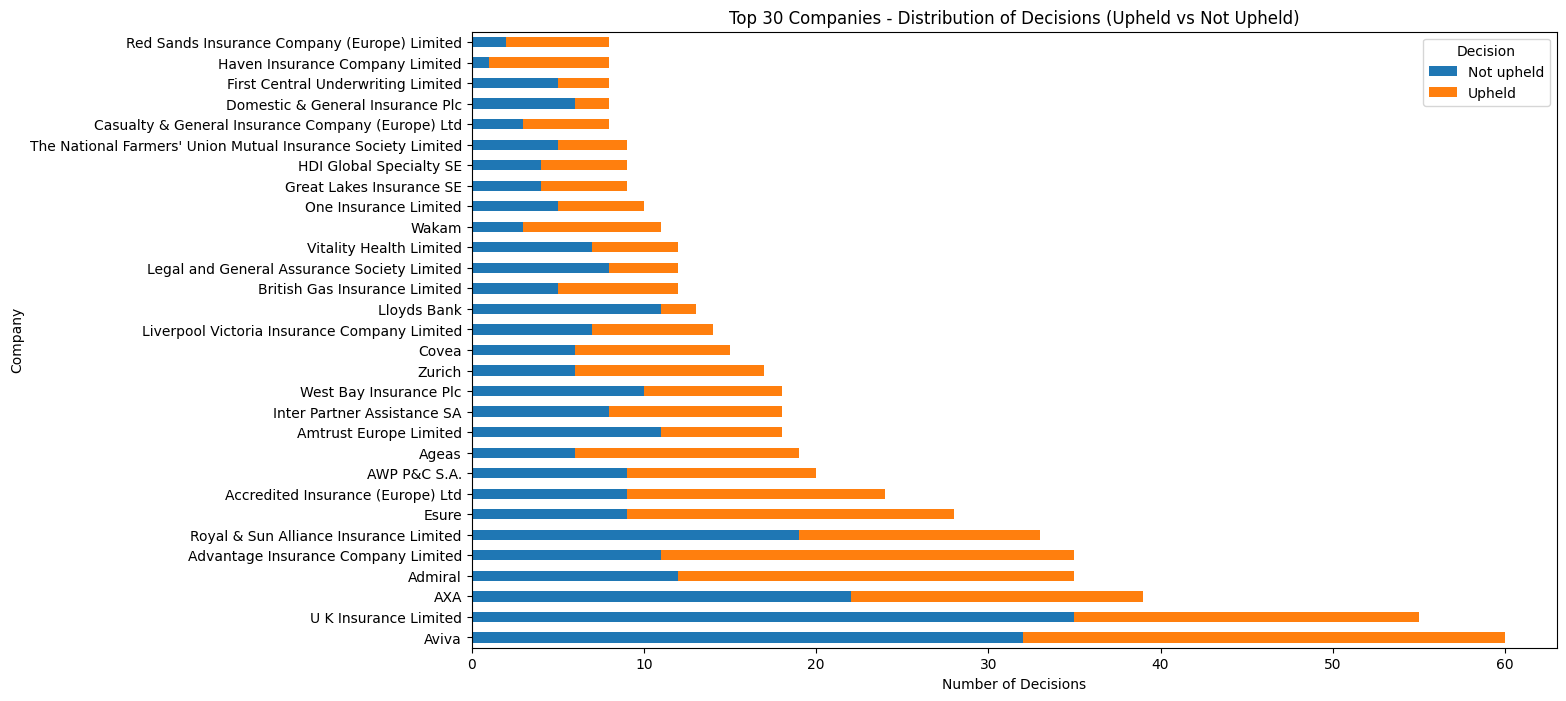

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistics
print(df['decision'].value_counts())

# Visualize the label distribution with a pie chart
plt.figure(figsize=(8, 6))
df['decision'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Label Distribution (Upheld vs Not Upheld)')
plt.ylabel('')  # Hide the y-label for better appearance
plt.show()

# Length of text analysis
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30)
plt.title('Distribution of Text Length')
plt.show()

# Aggregate decision counts by company
company_decision_counts = df.groupby(['company', 'decision']).size().unstack().fillna(0)

# Select the top 20 companies based on the total number of decisions
top_30_companies = company_decision_counts.sum(axis=1).nlargest(30).index
top_30_decision_counts = company_decision_counts.loc[top_30_companies]

# Plot stacked horizontal bar chart
top_30_decision_counts.plot(kind='barh', stacked=True, figsize=(14, 8))

plt.ylabel('Company')
plt.xlabel('Number of Decisions')
plt.title('Top 30 Companies - Distribution of Decisions (Upheld vs Not Upheld)')
plt.legend(title='Decision', loc='upper right')
plt.show()



### 5. Use of Embedding Techniques

### 6. Prediction of Claim Outcome with Hyperparameter Tuning

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Hyperparameter tuning for SVM
#param_grid_svm = {'C': [50, 100, 150], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']}
#grid_svm = GridSearchCV(SVC(), param_grid_svm, refit=True, verbose=2)
#grid_svm.fit(X_train_tfidf, y_train)

# Hyperparameter tuning for Random Forest
param_grid_rf = {'n_estimators': [200, 300, 400], 'max_features': ['auto', 'sqrt']}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, refit=True, verbose=2)
grid_rf.fit(X_train_tfidf, y_train)

# Hyperparameter tuning for Logistic Regression
param_grid_lr = {'C': [10, 50, 100, 150]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, refit=True, verbose=2)
grid_lr.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=400; total time=   0.0s
[CV] END ................max_features=auto, n_est

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/c

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ...............................................C=50; total time=   0.0s
[CV] END ..............................................C=100; total time=   0.0s
[CV] END ........................................

GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [10, 50, 100, 150]}, verbose=2)

In [5]:
# Best parameters from GridSearchCV for SVM
#print("Best parameters for SVM:", grid_svm.best_params_)

# Predictions and evaluation for SVM
#y_pred_svm = grid_svm.predict(X_test_tfidf)
#print("Support Vector Machine Classifier (TF-IDF):")
#print(classification_report(y_test, y_pred_svm))
#print(confusion_matrix(y_test, y_pred_svm))

In [25]:
# Best parameters from GridSearchCV for Random Forest
print("Best parameters for Random Forest:", grid_rf.best_params_)

# Predictions and evaluation for Random Forest
y_pred_rf = grid_rf.predict(X_test_tfidf)
print("Random Forest Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Best parameters for Random Forest: {'max_features': 'sqrt', 'n_estimators': 400}
Random Forest Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.88      0.84      0.86        87
      Upheld       0.84      0.88      0.86        81

    accuracy                           0.86       168
   macro avg       0.86      0.86      0.86       168
weighted avg       0.86      0.86      0.86       168

[[73 14]
 [10 71]]


In [26]:
# Best parameters from GridSearchCV for Logistic Regression
print("Best parameters for Logistic Regression:", grid_lr.best_params_)

# Predictions and evaluation for Logistic Regression
y_pred_lr = grid_lr.predict(X_test_tfidf)
print("Logistic Regression Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Best parameters for Logistic Regression: {'C': 50}
Logistic Regression Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.82      0.80      0.81        87
      Upheld       0.80      0.81      0.80        81

    accuracy                           0.81       168
   macro avg       0.81      0.81      0.81       168
weighted avg       0.81      0.81      0.81       168

[[70 17]
 [15 66]]


### 7. Extracting Insights and Recommendations

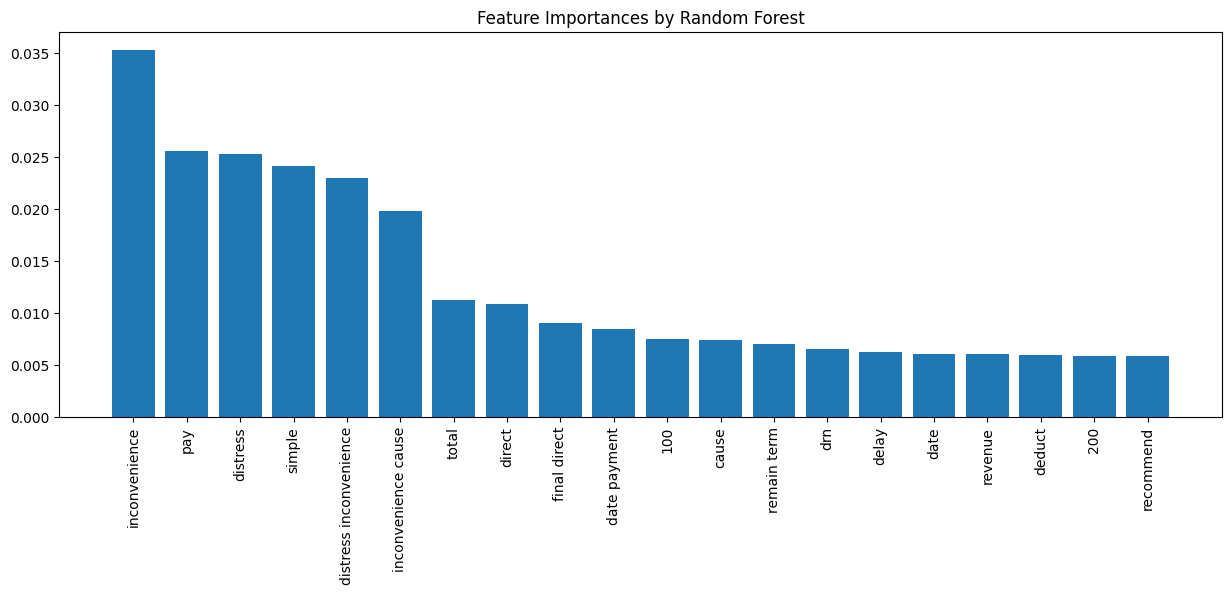

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Analyzing common words in complaints
from wordcloud import WordCloud

# Feature importance from Random Forest
importances = grid_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
features = vectorizer.get_feature_names_out()

# Plot feature importances
plt.figure(figsize=(15, 5))
plt.title("Feature Importances by Random Forest")
plt.bar(range(20), importances[indices][:20], align="center")
plt.xticks(range(20), [features[i] for i in indices[:20]], rotation=90)
plt.show()


In [9]:
df.head()

,filename,text,decision,company,text_length
0,04_24_Insurance_DRN-4552609.pdf,DRN-4552609 \n complaint \n Mr C complain AXIS...,Not upheld,AXIS Specialty Europe SE,593
1,04_24_Insurance_DRN-4647254.pdf,DRN-4647254 \n complaint \n Mr K policyholder ...,Not upheld,AXA Insurance UK Plc,448
2,04_24_Insurance_DRN-4764947.pdf,DRN-4764947 \n complaint \n Mrs B complain Arc...,Upheld,Arch Insurance (UK) Limited,1267
3,04_24_Insurance_DRN-4739493.pdf,DRN-4739493 \n complaint \n Mr N complain Roya...,Not upheld,Royal & Sun Alliance Insurance Limited,656
4,04_24_Insurance_DRN-4730514.pdf,DRN-4730514 \n complaint \n company refer c co...,Upheld,The National Farmers' Union Mutual Insurance S...,863


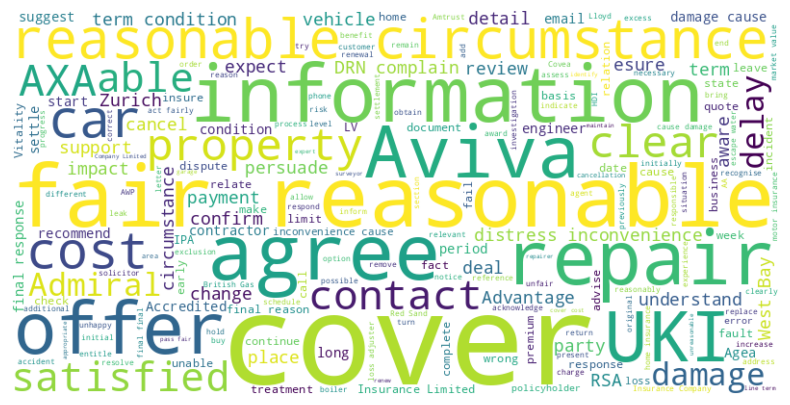

In [28]:
all_text = ' '.join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:

# Recommendations
def generate_recommendations(df):
    # Identify common issues in upheld decisions
    upheld_issues = df[df['decision'] == 'Upheld']['text']
    wordcloud_upheld = WordCloud(width=800, height=400, background_color='white').generate(' '.join(upheld_issues))

    # Identify common issues in not upheld decisions
    not_upheld_issues = df[df['decision'] == 'Not upheld']['text']
    wordcloud_not_upheld = WordCloud(width=800, height=400, background_color='white').generate(' '.join(not_upheld_issues))

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_upheld, interpolation='bilinear')
    plt.title('Common Issues in Upheld Decisions')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_not_upheld, interpolation='bilinear')
    plt.title('Common Issues in Not Upheld Decisions')
    plt.axis('off')

    plt.show()

    # Generate text-based insights
    print("Key recommendations based on the analysis:")
    print("1. Focus on improving product areas with high dispute rates.")
    print("2. Enhance customer service and complaint handling processes.")
    print("3. Regularly review and update product features to align with customer expectations.")
    print("4. Proactively identify and mitigate potential risks in new product developments.")

generate_recommendations(df)